In [1]:
from blimpy import Waterfall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

2023-09-04 02:11:12.285946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tqdm import tqdm
import gc
import keras
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = 8
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(
            name="kl_loss"
        )
        self.kl_additional = tf.keras.losses.KLDivergence()
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]
    def gaussanity_loss(self, data, base):
        return self.kl_additional(data, base)
    
    def train_step(self, data_in):
        data = data_in
        print(data.shape)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            
            total_loss = reconstruction_loss + self.beta * kl_loss
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    def test_step(self, data_in):
        data, _ = data_in
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        total_loss = reconstruction_loss + self.beta * kl_loss 
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        return {
            "test_loss": self.total_loss_tracker.result(),
            "test_kl_loss": self.kl_loss_tracker.result(),
            "test_reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    def __call__ (self, inputs):
        return self.decoder(self.encoder(inputs)[0])

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 10
time_samples = 16
freq_sample =  256
encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.BatchNormalization()(x)


z_mean = layers.Dense(32, activation="relu")(x)
z_mean = layers.BatchNormalization()(z_mean)
z_mean = layers.Dense(latent_dim, name="z_mean")(z_mean)

z_log_var = layers.Dense(32, activation="relu")(x)
z_log_var = layers.BatchNormalization()(z_log_var)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(z_log_var)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 16, 256, 32)  320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 128, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 128, 32)  128        ['max_pooling2d[0][0]']    

2023-09-04 02:11:28.700183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 02:11:29.082619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14233 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:61:00.0, compute capability: 8.6


                                                                                                  
 dense (Dense)                  (None, 256)          4194560     ['flatten[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 256)         1024        ['dense[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_1 (Dense)                (None, 32)           8224        ['batch_normalization_5[0][0]']  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32)          128         ['dense_1[0][0]']                
 rmalization)                                                                                     
          

In [4]:
autoencoder = VAE(encoder, decoder)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3))
# autoencoder.load_weights("../b-vae/models/full-weights-"+'06-11-2023-17-09-13')
autoencoder.load_weights("../b-vae/models/full-weights-"+'08-23-2023-21-05-49')

In [5]:
from tqdm import tqdm
def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:])
    return data

In [6]:
import pickle

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/test/")
count = 0
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        if '.' not in str(subfolder):
            for file in os.listdir(directory+folder+back+subfolder):
                file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
                if 'filtered.npy' in file_directory:
                    data.append(np.load(str(file_directory)))
                    count += 1
data = np.vstack(data)
print(data.shape)
preprocessed_data = np.expand_dims(normalize_data(data), axis = -1)

b'HIP104887-1850'
b'HIP87579-1008'
b'clustering_tests'
(347064, 16, 256)


100%|█████████████████████████████████| 347064/347064 [00:35<00:00, 9798.04it/s]


In [7]:
splits = preprocessed_data.shape[0] // 1_000
total_features = []
for i in tqdm(range(splits)):
    tensor = tf.convert_to_tensor(preprocessed_data[i*1_000:(i+1)*1_000, :,:,:], dtype=tf.float32)
    total_features.append(autoencoder.encoder(tensor)[0])
total_features = np.vstack(total_features)

print(total_features.shape)

  0%|                                                   | 0/347 [00:00<?, ?it/s]2023-09-04 02:12:12.322229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-09-04 02:12:15.629320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|█████████████████████████████████████████| 347/347 [00:25<00:00, 13.62it/s]


(347000, 10)


# Random Draw algo

In [8]:
from random import randint
from copy import deepcopy

def search_algo(total_features, SOI_features):
    SOI_norm = np.linalg.norm(SOI_features)
    data_norm = np.linalg.norm(total_features, axis = 1)
    similarity = np.matmul(total_features, SOI_features)
    similarity = np.divide(similarity, data_norm)/SOI_norm
    best_index = (-similarity).argsort()
    return best_index, similarity[best_index]

def search_remove(total_features, SOI_features, thresh = 0.9):
    best_index, similarity = search_algo(total_features, SOI_features)
    filtered = np.where(similarity < thresh)
    new_best_index = best_index[filtered]
    return new_best_index

In [9]:
# total_features_copy = deepcopy(total_features)
# print("initial step of removal",total_features_copy.shape[0], total_features_copy.shape)
# random_index = randint(0, total_features_copy.shape[0]-1)
# random_SOI = total_features_copy[random_index]
# remaining_index = search_remove(total_features_copy, random_SOI, thresh=-0.1)
# print(remaining_index.shape)
# total_features_copy = total_features[remaining_index, : ]
# print("Number of samples left", total_features_copy.shape[0])    
# count_iter += 1

In [10]:
from tqdm import tqdm
iters = []
thresholds = np.arange(-1,0.95, 0.001)
print(thresholds)
for i in tqdm(range(thresholds.shape[0])):
    thresh = thresholds[i]
    temp = []
    for i in range(10):
        total_features_copy = deepcopy(total_features)
        count_iter = 0
        while total_features_copy.shape[0] != 0:
            # print("initial step of removal",total_features_copy.shape[0], total_features_copy.shape)
            random_index = randint(0, total_features_copy.shape[0]-1)
            random_SOI = total_features_copy[random_index]
            remaining_index = search_remove(total_features_copy, random_SOI, thresh=thresh)
            total_features_copy = total_features[remaining_index, : ] 
            count_iter += 1
        temp.append(count_iter)
    iters.append([thresh, np.mean(temp), np.std(temp)])

[-1.    -0.999 -0.998 ...  0.947  0.948  0.949]


100%|███████████████████████████████████████| 1950/1950 [57:00<00:00,  1.75s/it]


Energy Detection on two targets totaling to 350,000 thousand signals.

(1950, 3)


(0.0, 100.0)

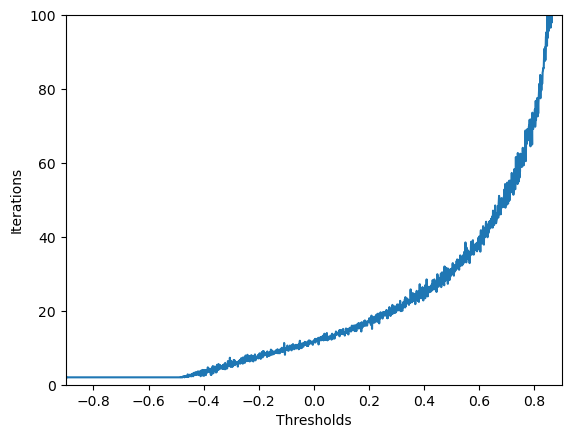

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
results = np.array(iters)
print(results.shape)

# plt.figure(figsize=(20,10))
plt.plot(results[:,0], results[:, 1])
plt.xlabel("Thresholds")
plt.ylabel("Iterations")
plt.xlim(-0.9, 0.9)
plt.ylim(0, 100)

(0.0, 100.0)

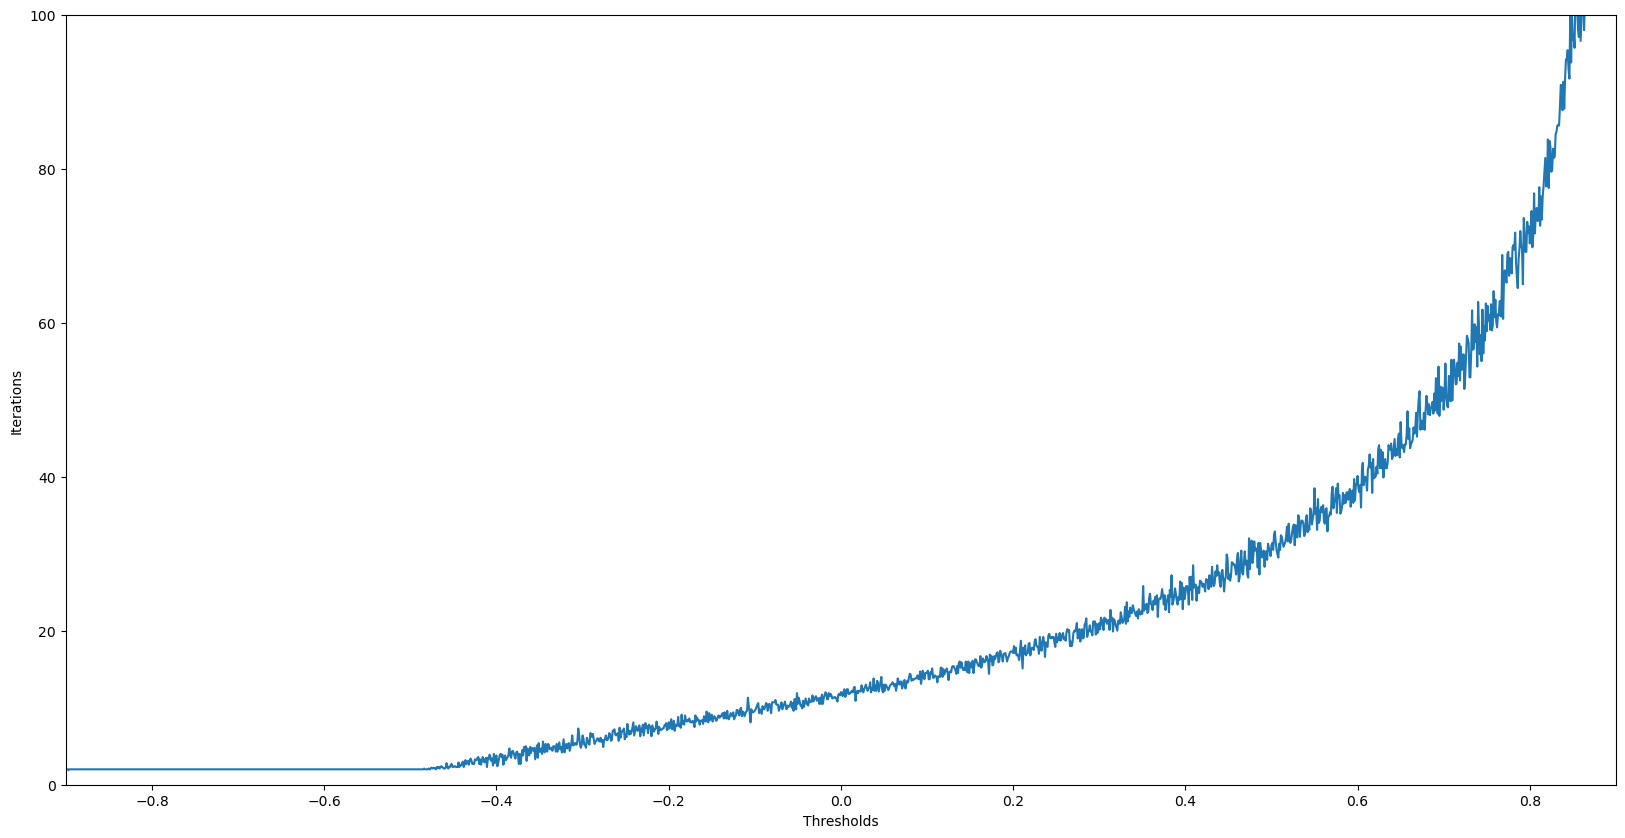

In [19]:
plt.figure(figsize=(20,10))
plt.plot(results[:,0], results[:, 1])
plt.xlabel("Thresholds")
plt.ylabel("Iterations")
plt.xlim(-0.9, 0.9)
plt.ylim(0, 100)

In [12]:
# from tqdm import tqdm
# iters = []
# thresholds = np.arange(0.9,1, 0.0001)
# for thresh in thresholds:
#     print()
#     print("New Threshold: ", thresh)
#     total_features_copy = deepcopy(total_features)
#     count_iter = 0
#     while total_features_copy.shape[0] != 0:
#         # print("initial step of removal",total_features_copy.shape[0], total_features_copy.shape)
#         random_index = randint(0, total_features_copy.shape[0]-1)
#         random_SOI = total_features_copy[random_index]
#         remaining_index = search_remove(total_features_copy, random_SOI, thresh=thresh)
#         total_features_copy = total_features[remaining_index, : ]
#         # print("Number of samples left", total_features_copy.shape[0])    
#         count_iter += 1
#     print("END REMOVAL Iteration Counter: ", count_iter)
#     iters.append([thresh, count_iter])

(1950, 3)


(0.999, 1.0)

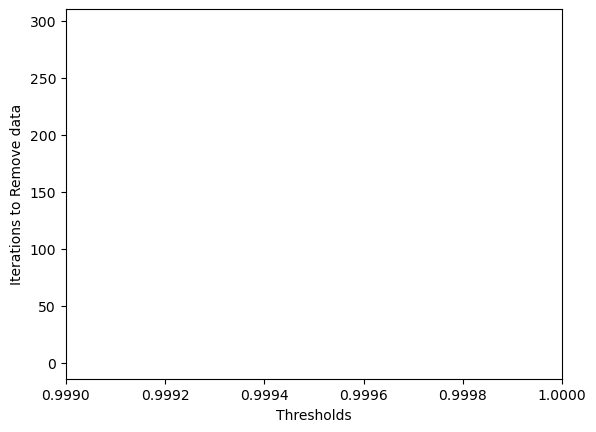

In [13]:
results = np.array(iters)
print(results.shape)

plt.figure()
plt.plot(results[:,0], results[:, 1])
plt.xlabel("Thresholds")
plt.ylabel("Iterations to Remove data")
plt.xlim(0.999,1)

In [39]:
total_features_copy = deepcopy(total_features)
saved_clusters = []
count_iter = 0
thresh = -0.1
while total_features_copy.shape[0] != 0:
    # print("initial step of removal",total_features_copy.shape[0], total_features_copy.shape)
    random_index = randint(0, total_features_copy.shape[0]-1)
    saved_clusters.append(random_index)
    random_SOI = total_features_copy[random_index]
    remaining_index = search_remove(total_features_copy, random_SOI, thresh=thresh)
    total_features_copy = total_features[remaining_index, : ]
    # print("Number of samples left", total_features_copy.shape[0])    
    count_iter += 1
print("END REMOVAL Iteration Counter: ", count_iter)

END REMOVAL Iteration Counter:  10


(10, 16, 256)


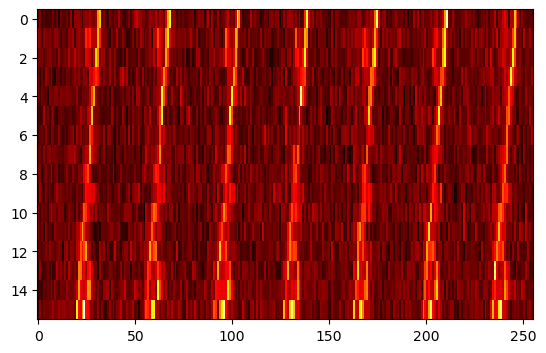

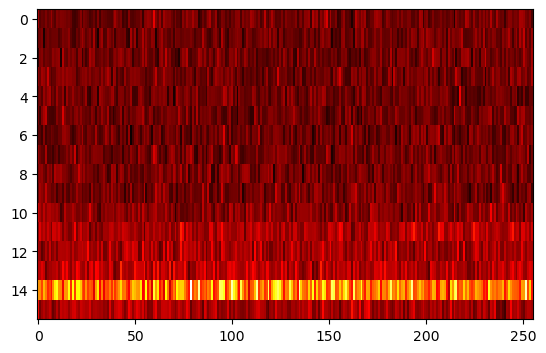

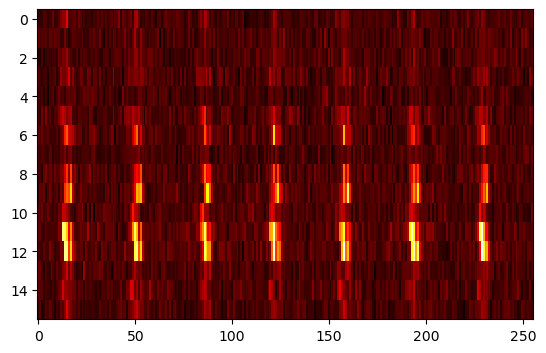

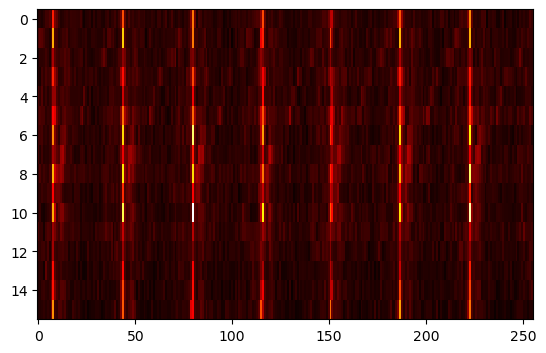

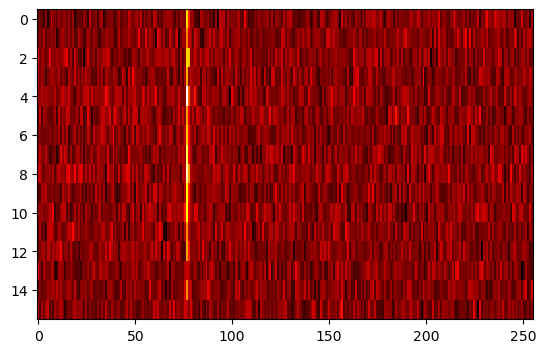

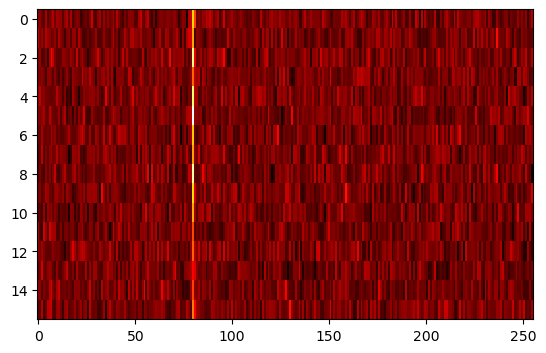

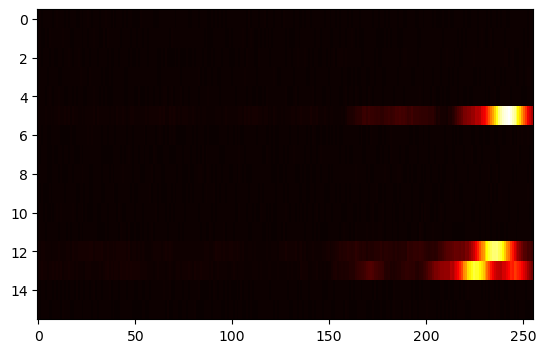

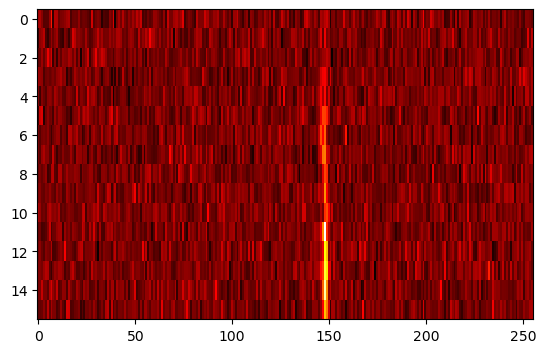

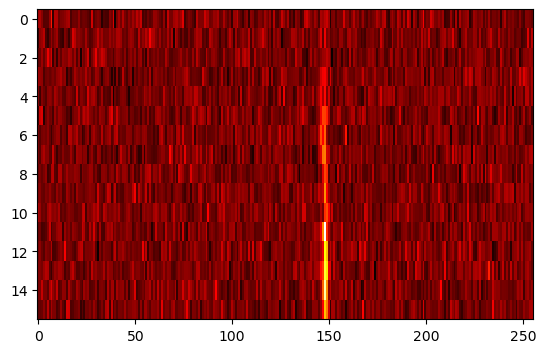

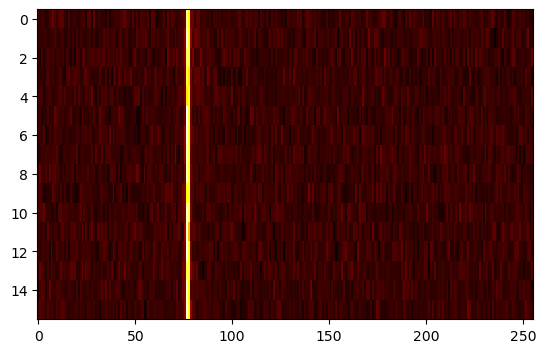

In [40]:
clusters = preprocessed_data[saved_clusters, :, :,0]
print(clusters.shape)

for i in range(clusters.shape[0]):
    plt.figure()
    plt.imshow(clusters[i,:, :], cmap='hot', interpolation='nearest', aspect=10)